In [1]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# All the functions

In [2]:
#define functions

#create function that finds mean of a function
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#create function that finds mean of a population
def weighted_total(a):
    weighted_total=0
    history_number=np.zeros((100,1)) #100 being the number of possible credit scores
    for i in range(100):
        number=sum(a==i) #number being the number of people having credit score i
        weighted_total+=number*i
        history_number[i]=number
    
    weighted_total/=sum(history_number)
    
    return weighted_total

#creates random distributions
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change



def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
    oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

    blues = true_blues.T
    oranges = true_oranges.T
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

# DO STUFF FOR A VERY LONG TIME

In [3]:
how_many_iters_ugh = 500
how_much_history = 10

history_initials_blue = np.zeros((how_many_iters_ugh, 1000))
history_initials_orange = np.zeros((how_many_iters_ugh, 1000))

history_final_blue_fair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_final_orange_fair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_cutoff_fair = np.zeros((how_many_iters_ugh, how_much_history, 2))

history_final_blue_unfair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_final_orange_unfair = np.zeros((how_many_iters_ugh, how_much_history, 1000))
history_cutoff_unfair = np.zeros((how_many_iters_ugh, how_much_history, 2))

In [4]:
for j in range(how_many_iters_ugh):
    
    if(j % 10 ==0):
        print("iteration", j)
    
    t = time.time()
    
    b_neutral, o_neutral, bwd_neutral, owd_neutral, mb, mo = create_blues_and_oranges()
    
    b_unfair = np.copy(b_neutral)
    o_unfair = np.copy(o_neutral)
    bwd_unfair = np.copy(bwd_neutral)
    owd_unfair = np.copy(owd_neutral)

    b_fair = np.copy(b_neutral)
    o_fair = np.copy(o_neutral)
    bwd_fair = np.copy(bwd_neutral)
    owd_fair = np.copy(owd_neutral)
    
    history_initials_blue[j] = b_neutral
    history_initials_orange[j] = o_neutral
    
    for i in range(how_much_history):

        #optimise cutoffs without fairness
        
        to_optimise = lambda x: total_bank_profit(b_unfair, o_unfair, bwd_unfair, 
                                                  owd_unfair, x[0], x[1])

        #initial guess
        cutoffs = np.zeros(2)
        cutoffs[0] = 50
        cutoffs[1] = 50


        #optimise without fairness
        a = (0, 100)
        bounds = (a, a)

        solution_unfair = minimize(to_optimise, cutoffs, 
                            bounds=bounds
                                   , options = {'eps': 3}
                                  )

        x_unfair = solution_unfair.x

        loans_b = b_unfair < x_unfair[0]
        loans_o = o_unfair < x_unfair[1]
        true_positives_b = np.logical_and(np.logical_not(bwd_unfair), np.logical_not(loans_b))
        false_positives_b = np.logical_and(np.logical_not(loans_b), bwd_unfair)

        true_positives_o = np.logical_and(np.logical_not(owd_unfair), np.logical_not(loans_o))
        false_positives_o = np.logical_and(np.logical_not(loans_o), owd_unfair)

        b_unfair[true_positives_b] +=5
        b_unfair[false_positives_b] -=10
        b_unfair[b_unfair<1] = 1
        b_unfair[b_unfair>99] = 99

        o_unfair[true_positives_o] +=5
        o_unfair[false_positives_o] -=10
        o_unfair[o_unfair<1] = 1
        o_unfair[o_unfair>99] = 99

        history_final_blue_unfair[j, i, :]=b_unfair
        history_final_orange_unfair[j, i, :]=o_unfair
        history_cutoff_unfair[i]=x_unfair

        bwd_unfair = b_unfair < np.random.randint(100, size=(1000,))
        owd_unfair = o_unfair < np.random.randint(100, size=(1000,))
    
    for i in range(how_much_history):
        
        #optimise cutoffs WITH fairness
        #what to optimise
        to_optimise = lambda x: total_bank_profit(b_fair, o_fair, bwd_fair, 
                                                  owd_fair, x[0], x[1])

        #what to constrain
        to_constrain = lambda x: difference_bw_positive_rates(b_fair, o_fair, bwd_fair, 
                                                              owd_fair, x[0], x[1])

        #initial guess
        cutoffs = np.zeros(2)
        cutoffs[0] = 50
        cutoffs[1] = 50

        a = (0, 100)
        bounds = (a, a)

        #name constraints
        equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
        cons = ([equal_true_positives])



        solution_fair = minimize(to_optimise, cutoffs, 
                            bounds=bounds, constraints=cons
                                   , options = {'eps': 3, 'maxiter':10}
                                  )

        x_fair = solution_fair.x


        loans_b = b_fair < x_fair[0]
        true_positives_b = np.logical_and(np.logical_not(loans_b), np.logical_not(bwd_fair))
        false_positives_b = np.logical_and(np.logical_not(loans_b), bwd_fair)


        loans_o = o_fair < x_fair[1]
        true_positives_o = np.logical_and(np.logical_not(loans_o), np.logical_not(owd_fair))
        false_positives_o = np.logical_and(np.logical_not(loans_o), owd_fair)

        b_fair[true_positives_b] +=5
        b_fair[false_positives_b] -=10
        b_fair[b_fair<1] = 1
        b_fair[b_fair>99] = 99

        o_fair[true_positives_o] +=5
        o_fair[false_positives_o] -=10
        o_fair[o_fair<1] = 1
        o_fair[o_fair>99] = 99

#         b_fair-=0.5
#         o_fair-=0.5

        history_final_blue_fair[j,i,:]=b_fair
        history_final_orange_fair[j,i,:]=o_fair
        history_cutoff_fair[j,i,:]=x_fair
        

        bwd_fair = b_fair < np.random.randint(100, size=(1000,))
        owd_fair = o_fair < np.random.randint(100, size=(1000,))
    
    if (j % 50 == 0):
        print("50 iterations took", (time.time() - t)/60, "minutes")


iteration 0
50 iterations took 0.6292333205540975 minutes
iteration 10
iteration 20
iteration 30


/anaconda/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
/anaconda/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
/anaconda/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in less
/anaconda/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in less


iteration 40
iteration 50
50 iterations took 0.6030548493067424 minutes
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
50 iterations took 0.5410187363624572 minutes
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
50 iterations took 0.6242139975229899 minutes
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
50 iterations took 0.7110395510991414 minutes
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
50 iterations took 0.6332014679908753 minutes
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
50 iterations took 0.7779568831125895 minutes
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
50 iterations took 0.7085332155227662 minutes
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
50 iterations took 0.5789123018582661 minutes
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
50 iterations took 0.690673021475474 minutes
itera

Infrastructure to analyse stuff

In [5]:
# history_initials_blue
# history_initials_orange

# history_final_blue_fair
# history_final_orange_fair
# history_cutoff_fair

# history_final_blue_unfair
# history_final_orange_unfair
# history_cutoff_unfair

In [6]:
weighted_total(history_final_blue_fair[0,2,:])

array([35.408])

In [7]:
fairs_blue = np.zeros((how_many_iters_ugh, how_much_history))
unfairs_blue = np.zeros((how_many_iters_ugh, how_much_history))
fairs_orange = np.zeros((how_many_iters_ugh, how_much_history))
unfairs_orange = np.zeros((how_many_iters_ugh, how_much_history))

In [8]:
for j in range(how_many_iters_ugh):    
    
    print("iteration", j)
    
    t = time.time()
    
    for i in range(how_much_history):
        
        fairs_blue[j,i] = weighted_total(history_final_blue_fair[j,i,:])
        unfairs_blue[j,i] =  weighted_total(history_final_blue_unfair[j,i,:])
        fairs_orange[j,i] = weighted_total(history_final_orange_fair[j,i,:])
        unfairs_orange[j,i] =  weighted_total(history_final_orange_unfair[j,i,:])
        
    print("one iteration took", time.time() - t, "seconds")

iteration 0
one iteration took 10.543122053146362 seconds
iteration 1
one iteration took 10.848273992538452 seconds
iteration 2
one iteration took 10.629408121109009 seconds
iteration 3
one iteration took 10.347086906433105 seconds
iteration 4
one iteration took 10.53053331375122 seconds
iteration 5
one iteration took 11.055007934570312 seconds
iteration 6
one iteration took 14.602033853530884 seconds
iteration 7
one iteration took 13.5629141330719 seconds
iteration 8
one iteration took 11.295936107635498 seconds
iteration 9
one iteration took 10.493208885192871 seconds
iteration 10
one iteration took 11.887367248535156 seconds
iteration 11
one iteration took 10.955497980117798 seconds
iteration 12
one iteration took 10.374873161315918 seconds
iteration 13
one iteration took 10.337922096252441 seconds
iteration 14
one iteration took 11.75898003578186 seconds
iteration 15
one iteration took 12.416213989257812 seconds
iteration 16
one iteration took 10.651891946792603 seconds
iteration 1

one iteration took 10.228540182113647 seconds
iteration 139
one iteration took 11.242828130722046 seconds
iteration 140
one iteration took 10.938946008682251 seconds
iteration 141
one iteration took 11.671512126922607 seconds
iteration 142
one iteration took 10.875598907470703 seconds
iteration 143
one iteration took 11.958479881286621 seconds
iteration 144
one iteration took 10.194975137710571 seconds
iteration 145
one iteration took 11.089995861053467 seconds
iteration 146
one iteration took 11.212541103363037 seconds
iteration 147
one iteration took 11.304979801177979 seconds
iteration 148
one iteration took 11.412081003189087 seconds
iteration 149
one iteration took 11.16138219833374 seconds
iteration 150
one iteration took 10.91759991645813 seconds
iteration 151
one iteration took 11.04426383972168 seconds
iteration 152
one iteration took 10.992576122283936 seconds
iteration 153
one iteration took 13.717457056045532 seconds
iteration 154
one iteration took 14.238092184066772 secon

one iteration took 10.984577894210815 seconds
iteration 277
one iteration took 10.19986367225647 seconds
iteration 278
one iteration took 10.175940752029419 seconds
iteration 279
one iteration took 10.127767086029053 seconds
iteration 280
one iteration took 13.261329889297485 seconds
iteration 281
one iteration took 11.992449045181274 seconds
iteration 282
one iteration took 11.308000087738037 seconds
iteration 283
one iteration took 13.395562171936035 seconds
iteration 284
one iteration took 13.155117988586426 seconds
iteration 285
one iteration took 11.236786127090454 seconds
iteration 286
one iteration took 12.16395902633667 seconds
iteration 287
one iteration took 11.00983190536499 seconds
iteration 288
one iteration took 10.122794151306152 seconds
iteration 289
one iteration took 10.396269083023071 seconds
iteration 290
one iteration took 10.12169075012207 seconds
iteration 291
one iteration took 10.370482921600342 seconds
iteration 292
one iteration took 10.263744115829468 second

iteration 414
one iteration took 10.55184006690979 seconds
iteration 415
one iteration took 10.316855192184448 seconds
iteration 416
one iteration took 10.739083051681519 seconds
iteration 417
one iteration took 10.518404960632324 seconds
iteration 418
one iteration took 10.239006996154785 seconds
iteration 419
one iteration took 10.788473129272461 seconds
iteration 420
one iteration took 10.324211835861206 seconds
iteration 421
one iteration took 10.367899894714355 seconds
iteration 422
one iteration took 10.244619131088257 seconds
iteration 423
one iteration took 10.714043140411377 seconds
iteration 424
one iteration took 10.770328760147095 seconds
iteration 425
one iteration took 10.99133014678955 seconds
iteration 426
one iteration took 10.16552209854126 seconds
iteration 427
one iteration took 10.257382154464722 seconds
iteration 428
one iteration took 10.272917032241821 seconds
iteration 429
one iteration took 10.258415937423706 seconds
iteration 430
one iteration took 10.2645649

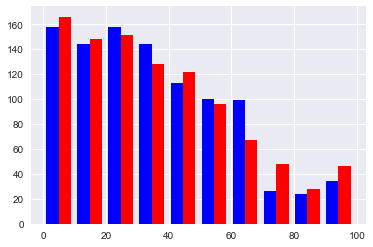

In [9]:
plt.hist([history_initials_blue[2,:], history_initials_orange[2,:]] ,color=['b', 'r'])
plt.show()

In [17]:
print(fairs_blue.shape)

(500, 10)


In [61]:
print(fairs_blue[0])

[35.025 35.231 35.408 35.615 35.635 35.81  35.865 35.941 36.036 36.13 ]


In [56]:
distribution_over_regressions = np.copy(fairs_blue)
distribution_over_regressions = distribution_over_regressions[:,9]-distribution_over_regressions[:,0]
droppers = distribution_over_regressions < -3.7
distribution_over_regressions = distribution_over_regressions[droppers]

print(sum(distribution_over_regressions < -3.7))

6


In [129]:
for i in range(len(droppers)):
    if droppers[i]:
        print (i)

167
203
266
299
444
469


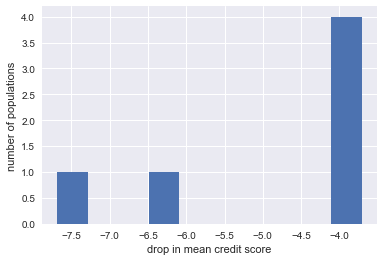

In [57]:
plt.hist(distribution_over_regressions)
plt.xlabel("drop in mean credit score")
plt.ylabel("number of populations")
plt.show()

In [58]:
big_drop_blues = history_initials_blue[droppers]
big_drop_oranges = history_initials_orange[droppers]


In [202]:
print(np.average(big_drop_blues, axis=1))
print(np.average(big_drop_oranges, axis=1))

[42.398 38.046 33.084 38.174 36.901 39.324]
[56.695 58.733 50.307 69.771 65.833 60.173]


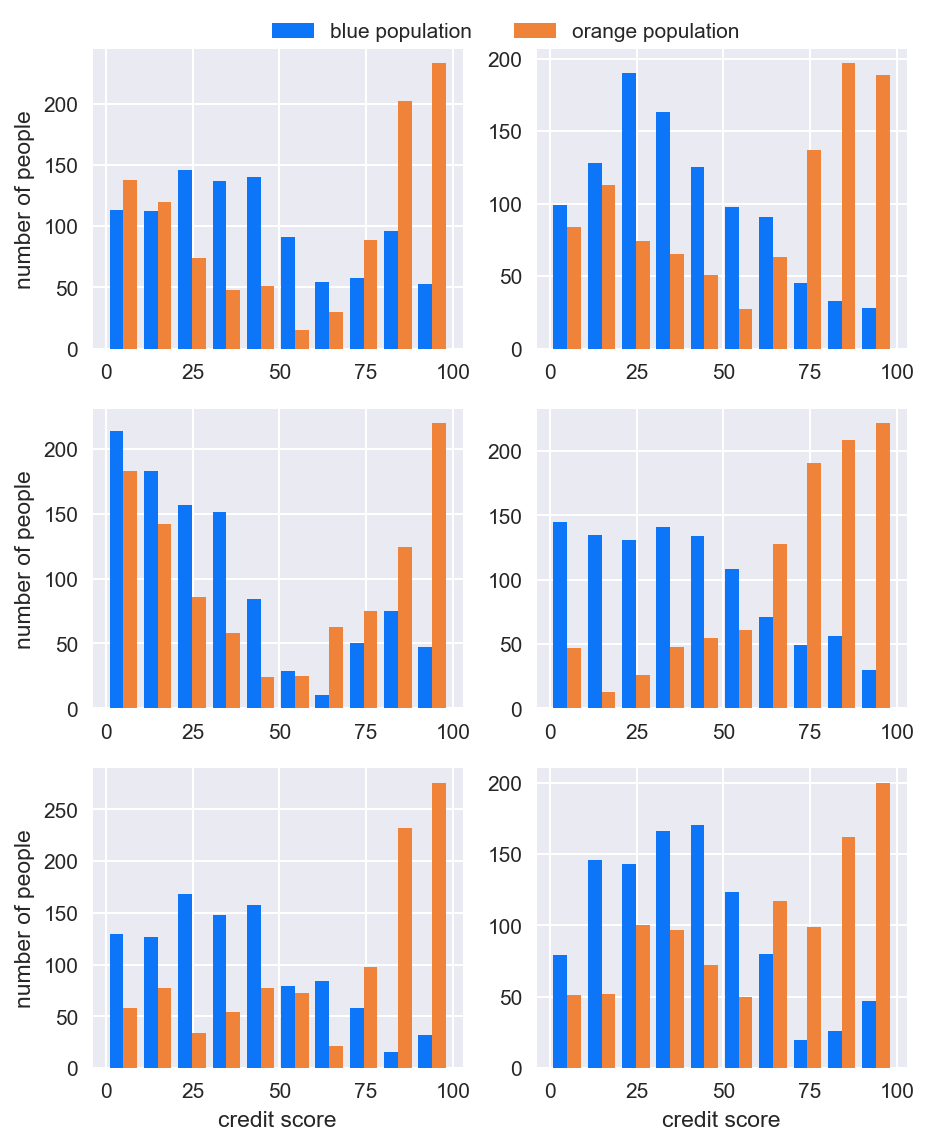

In [197]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")


for i in range(6):

    plt.subplot(3, 2, i+1)

    plt.hist([big_drop_blues[i], big_drop_oranges[i]], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        plt.legend(("blue population", "orange population"), bbox_to_anchor=(1.8, 1.15), ncol=2)
#         plt.legend(("blue population", "orange population"))
    
    if(i==2):
        plt.ylabel("number of people")
        
    if(i==4):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        
    if(i==5):
        plt.xlabel("credit score")
        

plt.savefig("plots/worst_offenders.pdf")
plt.show()

In [139]:
fairs_blue[450:455].shape

(5, 10)

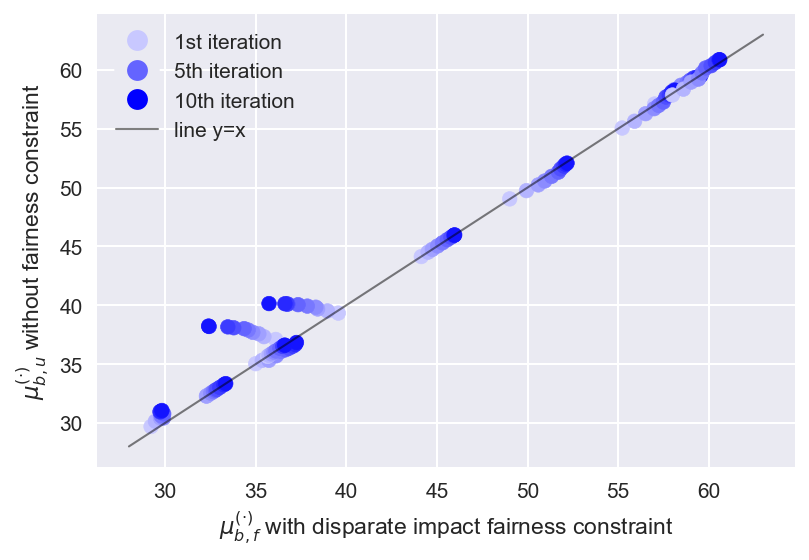

In [218]:
row_number = how_many_iters_ugh*how_much_history

colours = np.zeros((row_number, 4))
colours[:,3] = 1
colours[:,0:2] = 200/255
colours[:,2] = 255/255
for i in range(row_number):
    colours[i,0:2]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(200/255,200/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(100/255,100/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(0/255,0/255,255/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(np.concatenate((fairs_blue[443:445], fairs_blue[468:471], fairs_blue[52:55], fairs_blue[80:83])), 
           np.concatenate((unfairs_blue[443:445],unfairs_blue[468:471], unfairs_blue[52:55], fairs_blue[80:83])), 
           c=colours)
ax.plot(np.linspace(28,63), np.linspace(28,63), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu^{(\cdot)}_{b,u}$ without fairness constraint")
ax.set_xlabel("$\mu^{(\cdot)}_{b,f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/GOOD_evolution_blues.pdf")
plt.show()

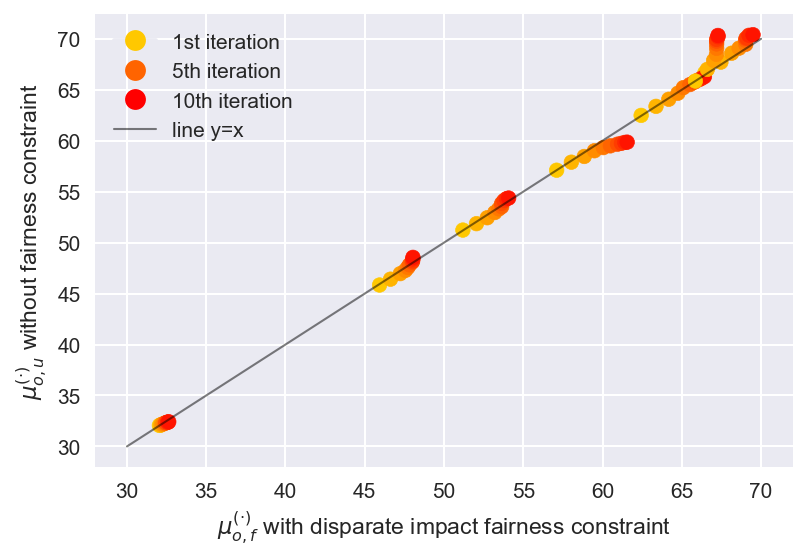

In [217]:
num_its = how_many_iters_ugh*how_much_history

colours_orange = np.zeros((num_its, 4))
colours_orange[:,3] = 1
colours_orange[:,0] = 255/255
colours_orange[:,1] = 200/255
colours_orange[:,2] = 0/255
for i in range(num_its):
    colours_orange[i,1]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(255/255,200/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(255/255,100/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(255/255,0/255,0/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(fairs_orange[55:62], unfairs_orange[55:62], c=colours_orange)
ax.plot(np.linspace(30,70), np.linspace(30,70), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu^{(\cdot)}_{o, u}$ without fairness constraint")
ax.set_xlabel("$\mu^{(\cdot)}_{o, f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/GOOD_evolution_oranges.pdf")
plt.show()

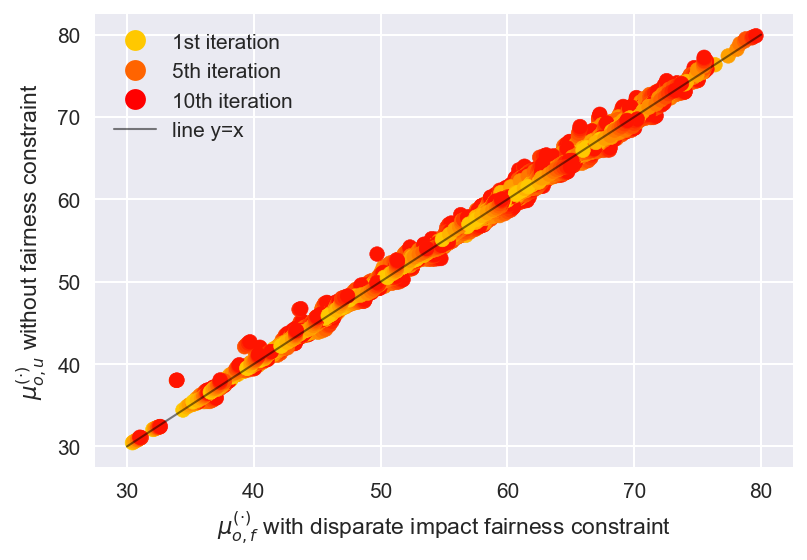

In [222]:
num_its = how_many_iters_ugh*how_much_history

colours_orange = np.zeros((num_its, 4))
colours_orange[:,3] = 1
colours_orange[:,0] = 255/255
colours_orange[:,1] = 200/255
colours_orange[:,2] = 0/255
for i in range(num_its):
    colours_orange[i,1]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(255/255,200/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(255/255,100/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(255/255,0/255,0/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(fairs_orange, unfairs_orange, c=colours_orange)
ax.plot(np.linspace(30,80), np.linspace(30,80), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu^{(\cdot)}_{o, u}$ without fairness constraint")
ax.set_xlabel("$\mu^{(\cdot)}_{o, f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/appendixorange.pdf")
plt.show()

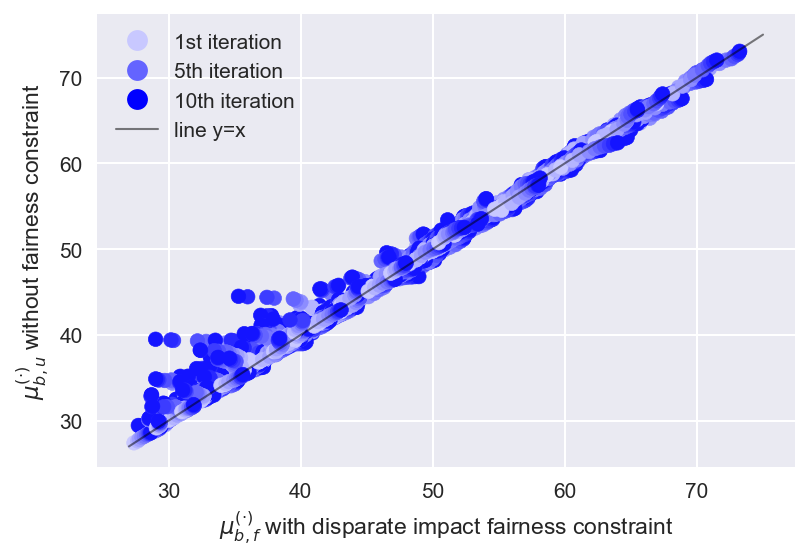

In [227]:
row_number = how_many_iters_ugh*how_much_history

colours = np.zeros((row_number, 4))
colours[:,3] = 1
colours[:,0:2] = 200/255
colours[:,2] = 255/255
for i in range(row_number):
    colours[i,0:2]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(200/255,200/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(100/255,100/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(0/255,0/255,255/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(fairs_blue, unfairs_blue, c=colours)
ax.plot(np.linspace(27,75), np.linspace(27,75), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu^{(\cdot)}_{b,u}$ without fairness constraint")
ax.set_xlabel("$\mu^{(\cdot)}_{b,f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/appendixblue.pdf")
plt.show()

## Two plots

In [ ]:
row_number = how_many_iters_ugh*how_much_history

colours = np.zeros((row_number, 4))
colours[:,3] = 1
colours[:,0:2] = 200/255
colours[:,2] = 255/255
for i in range(row_number):
    colours[i,0:2]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(200/255,200/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(100/255,100/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(0/255,0/255,255/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(np.concatenate((fairs_blue[443:445], fairs_blue[468:471], fairs_blue[52:55], fairs_blue[80:83])), 
           np.concatenate((unfairs_blue[443:445],unfairs_blue[468:471], unfairs_blue[52:55], fairs_blue[80:83])), 
           c=colours)
ax.plot(np.linspace(28,63), np.linspace(28,63), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\mu_o$ without fairness constraint")
ax.set_xlabel("$\mu_o$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_blues.pdf")
plt.show()

In [66]:
std_devs_fair = np.zeros((500,10))
std_devs_unfair = np.zeros((500,10))

for i in range(500):
    for j in range(10):
        std_devs_fair[i,j] = np.std(history_final_blue_fair[i,j,:])
        std_devs_unfair[i,j] = np.std(history_final_blue_unfair[i,j,:])

In [85]:
std_devs_fair_orange = np.zeros((500,10))
std_devs_unfair_orange = np.zeros((500,10))

for i in range(500):
    for j in range(10):
        std_devs_fair_orange[i,j] = np.std(history_final_orange_fair[i,j,:])
        std_devs_unfair_orange[i,j] = np.std(history_final_orange_unfair[i,j,:])

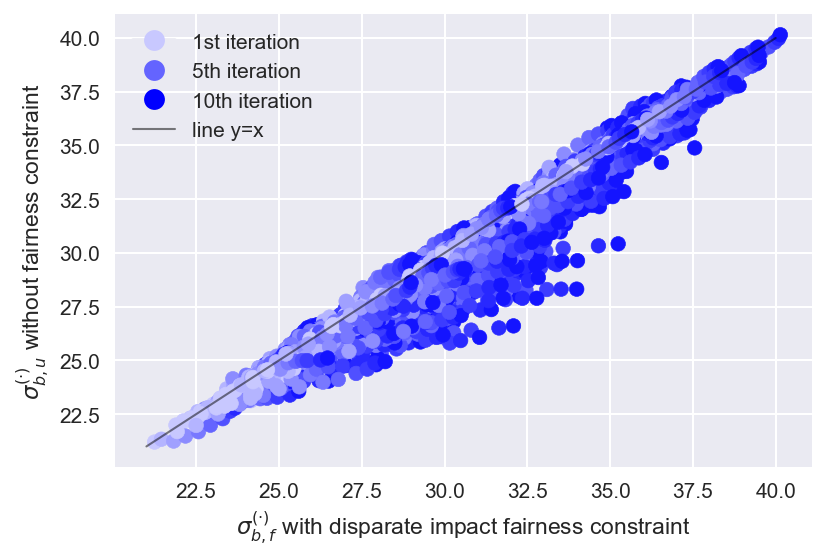

In [219]:
row_number = how_many_iters_ugh*how_much_history

colours = np.zeros((row_number, 4))
colours[:,3] = 1
colours[:,0:2] = 200/255
colours[:,2] = 255/255
for i in range(row_number):
    colours[i,0:2]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(200/255,200/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(100/255,100/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(0/255,0/255,255/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(std_devs_fair, std_devs_unfair, c=colours)
ax.plot(np.linspace(21,40), np.linspace(21,40), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\sigma^{(\cdot)}_{b,u}$ without fairness constraint")
ax.set_xlabel("$\sigma^{(\cdot)}_{b,f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_blues_std_dev_all.pdf")
plt.show()

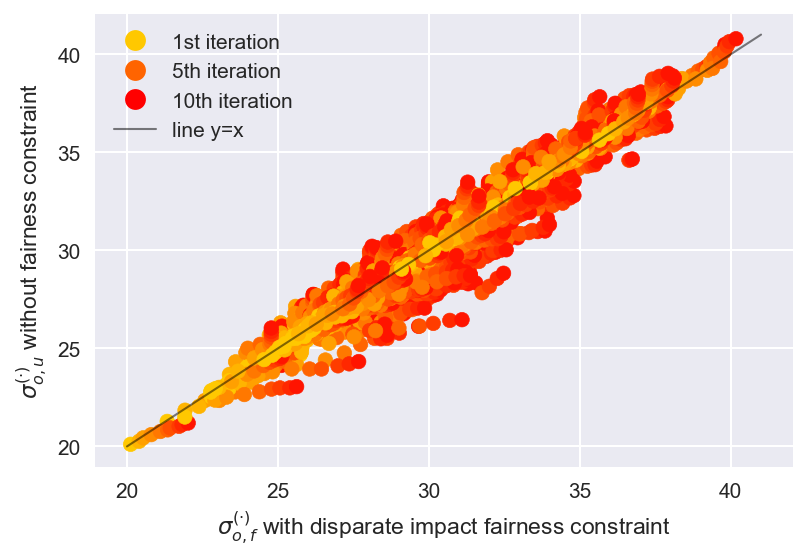

In [220]:
row_number = how_many_iters_ugh*how_much_history

colours_orange = np.zeros((num_its, 4))
colours_orange[:,3] = 1
colours_orange[:,0] = 255/255
colours_orange[:,1] = 200/255
colours_orange[:,2] = 0/255
for i in range(num_its):
    colours_orange[i,1]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(255/255,200/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(255/255,100/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(255/255,0/255,0/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(std_devs_fair_orange[20,35], std_devs_unfair_orange[20,35], c=colours_orange)
ax.plot(np.linspace(20,41), np.linspace(20,41), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\sigma^{(\cdot)}_{o,u}$ without fairness constraint")
ax.set_xlabel("$\sigma^{(\cdot)}_{o,f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_oranges_std_dev_all.pdf")
plt.show()

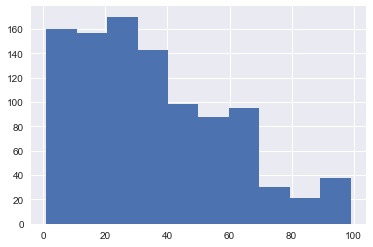

In [14]:
plt.hist(history_final_blue_fair[9,0,:])
plt.show()

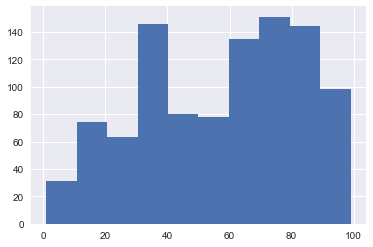

In [15]:
plt.hist(history_final_orange_fair[9,0,:])
plt.show()

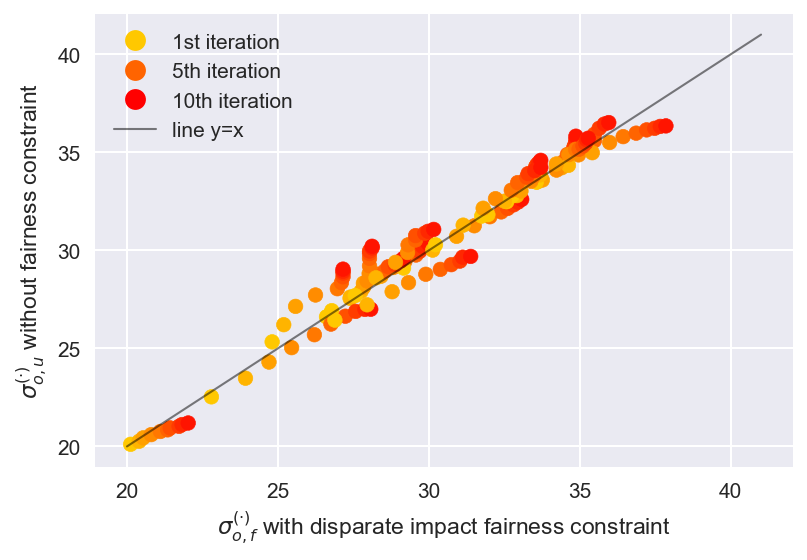

In [233]:
row_number = how_many_iters_ugh*how_much_history

colours_orange = np.zeros((num_its, 4))
colours_orange[:,3] = 1
colours_orange[:,0] = 255/255
colours_orange[:,1] = 200/255
colours_orange[:,2] = 0/255
for i in range(num_its):
    colours_orange[i,1]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(255/255,200/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(255/255,100/255,0/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(255/255,0/255,0/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(std_devs_fair_orange[55:70], std_devs_unfair_orange[55:70], c=colours_orange)
ax.plot(np.linspace(20,41), np.linspace(20,41), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\sigma^{(\cdot)}_{o,u}$ without fairness constraint")
ax.set_xlabel("$\sigma^{(\cdot)}_{o,f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_oranges_std_dev.pdf")
plt.show()

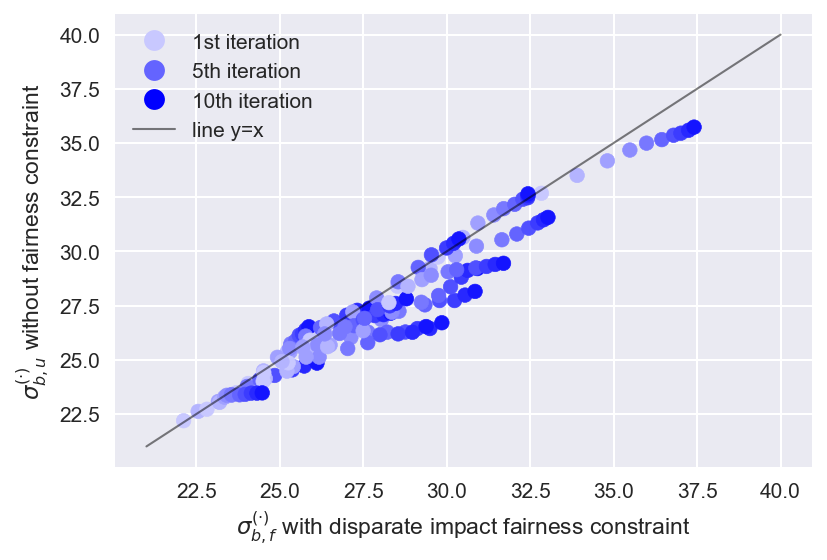

In [235]:
row_number = how_many_iters_ugh*how_much_history

colours = np.zeros((row_number, 4))
colours[:,3] = 1
colours[:,0:2] = 200/255
colours[:,2] = 255/255
for i in range(row_number):
    colours[i,0:2]-= (i % how_much_history)*200/255/how_much_history

legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='1st iteration',
                          markerfacecolor=(200/255,200/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='5th iteration',
                          markerfacecolor=(100/255,100/255,255/255), markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='10th iteration',
                          markerfacecolor=(0/255,0/255,255/255), markersize=10),
                   Line2D([0], [0], label='line y=x', color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()
fig.set_dpi(150)
# fig = plt.scatter(fairs_blue, unfairs_blue, c=colours)
ax.scatter(std_devs_fair[55:70], std_devs_unfair[55:70], c=colours)
ax.plot(np.linspace(21,40), np.linspace(21,40), linewidth=1, c='black', alpha=0.5)
ax.set_ylabel("$\sigma^{(\cdot)}_{b,u}$ without fairness constraint")
ax.set_xlabel("$\sigma^{(\cdot)}_{b,f}$ with disparate impact fairness constraint")
ax.legend(handles=legend_elements, loc='best')
plt.savefig("plots/evolution_blues_std_dev.pdf")
plt.show()